# XGBoost Tuning (Descriptors + Fingerprints)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, MACCSkeys
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)

import xgboost as xgb
from xgboost import XGBClassifier
import shap
import optuna


## Molecule, Descriptor + Fingerprints and Outlier Functions

In [ ]:
def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # Re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors


def compute_iqr_limits(df, factor=1.5):
    # Calculate IQR limits
    limits = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat - skip
        if iqr == 0 or np.isnan(iqr):
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        limits[col] = (lower, upper)
    return limits


def apply_iqr_limits(df, limits):
    # Apply the limits
    df_clipped = df.copy()
    for col, (lower, upper) in limits.items():
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped


def bitvect_to_dict(fp, prefix):
    # Convert bit vector to dictionary (create features)
    n_bits = fp.GetNumBits()
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    features = {}
    for i, v in enumerate(arr):
        features[f"{prefix}_{i}"] = int(v)
    return features


def calculate_fingerprints(mol):
    RDLogger.DisableLog('rdApp.*')
    # Calculate Morgan, RDKit, MACCS, AtomPair and Topological Torsion fingerprint
    feats = {}
    if mol is None:
        return feats

    # Morgan (ECFP) fingerprint
    morgan_bits = 2048
    morgan_radius = 2
    fp_morgan = rdMolDescriptors.GetMorganFingerprintAsBitVect(
        mol, radius=morgan_radius, nBits=morgan_bits
    )
    feats.update(bitvect_to_dict(fp_morgan, f"Morgan{morgan_radius}_{morgan_bits}"))

    # RDKit topological fingerprint
    rdk_bits = 2048
    fp_rdk = Chem.RDKFingerprint(mol, fpSize=rdk_bits)
    feats.update(bitvect_to_dict(fp_rdk, f"RDK_{rdk_bits}"))

    # MACCS keys (167 bits)
    fp_maccs = MACCSkeys.GenMACCSKeys(mol)
    feats.update(bitvect_to_dict(fp_maccs, "MACCS"))

    # AtomPair fingerprint
    ap_bits = 2048
    fp_ap = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=ap_bits)
    feats.update(bitvect_to_dict(fp_ap, f"AtomPair_{ap_bits}"))

    # Topological torsion fingerprint
    tt_bits = 2048
    fp_tt = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=tt_bits)
    feats.update(bitvect_to_dict(fp_tt, f"Torsion_{tt_bits}"))
    
    RDLogger.EnableLog('rdApp.*')

    return feats

## Dataset Processing

In [6]:
# Configuration
ORIG_DATASET = "in_chemico_dataset.xlsx"
SKIP_ROWS = 1
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
FULL_OUTPUT_DATASET = "in_chemico_dataset_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"

# Near constant threshold - tolerance
SIMILARITY_THRESHOLD = 0.7
# Correlation threshold
CORRELATION_THRESHOLD = 0.65

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

descriptor_rows = []
state_molecules = []
molecules = []

for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    if molecule is None:
        descriptor_rows.append({})
        continue

    # 1D/2D RDKit descriptors
    desc_feats = calculate_descriptors(molecule)

    # Calculate Morgan, RDKit, MACCS, AtomPair and Topological Torsion fingerprint
    fp_feats = calculate_fingerprints(molecule)

    # Merge both dicts into one feature row
    all_feats = {**desc_feats, **fp_feats}
    descriptor_rows.append(all_feats)

# Convert list of dictionaries into dataframe
descriptor_data_all = pd.DataFrame(descriptor_rows)

# Keep everything + status
output = pd.concat(
    [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)],
    axis=1
)
output["MoleculeStatus"] = state_molecules

# Output whole dataset with descriptors and state
with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Drop failed molecules - boolean array
molecules_right = []
for molecule in molecules:
    if molecule is not None:
        molecules_right.append(True)
    else:
        molecules_right.append(False)
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Take only numeric descriptor columns
X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
for column in X_full.columns:
    X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)

# Split dataset - train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Calculate medians for each column in train only
train_medians = X_train.median(numeric_only=True)

# Fill missing values in both train and test using those medians
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Compute constants on train only
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

# Drop from train and apply same drop to test
if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

# Compute absolute correlation matrix on training data
corr_matrix = X_train.corr().abs()
# Keep only upper triangle of the matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find columns to drop - correlation
high_corr_cols = []
for col in upper.columns:
    if any(upper[col] > CORRELATION_THRESHOLD):
        high_corr_cols.append(col)

# Drop from both train and test
if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated columns.")

# Compute IQR limits on training data
iqr_limits = compute_iqr_limits(X_train, factor=1.5)

# Apply limits to both train and test sets
X_train = apply_iqr_limits(X_train, iqr_limits)
X_test = apply_iqr_limits(X_test, iqr_limits)

# Scaling not necessary for all models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
print("First rows of train x:")
print(X_train.head().to_string(index=False))
print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
print("First rows of train y:")
print(y_train.head().to_string(index=False))
X_train.describe()

print("\nTrain set class counts:")
print(y_train.value_counts())
print("\nTrain set class ratio:")
print(y_train.value_counts(normalize=True))

print("\nTest set class counts:")
print(y_test.value_counts())
print("\nTest set class ratio:")
print(y_test.value_counts(normalize=True))

Full - Rows: 162/Columns: 8589
                          Name                                                                                              IUPAC name CAS registry number    Structure  Phototoxicity                                                      SMILES code                            Sources               Note    Unnamed: 8 Unnamed: 9  Unnamed: 10 Unnamed: 11  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex      qed       SPS   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_MRLOW   AvgIpc  BalabanJ    BertzCT      Chi0     Chi0n     Chi0v      Chi1    Chi1n    Chi1v    Chi2n    Chi2v    Chi3n    Chi3v    Chi4n    Chi4v  HallKierAlpha           Ipc    Kappa1   Kappa2   Kappa3  Labut

## Base Model Train

In [7]:
base_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42
)
# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nModel performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Model performance:
Accuracy:  0.7273
Precision: 0.8000
Recall:    0.6667
F1 score:  0.7273
ROC AUC:   0.8000

Classification report:
              precision    recall  f1-score   support

           0      0.667     0.800     0.727        15
           1      0.800     0.667     0.727        18

    accuracy                          0.727        33
   macro avg      0.733     0.733     0.727        33
weighted avg      0.739     0.727     0.727        33



## Feature Selection

PermutationExplainer explainer: 130it [02:08,  1.04s/it]                         
/tmp/ipykernel_13369/582230141.py:38: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


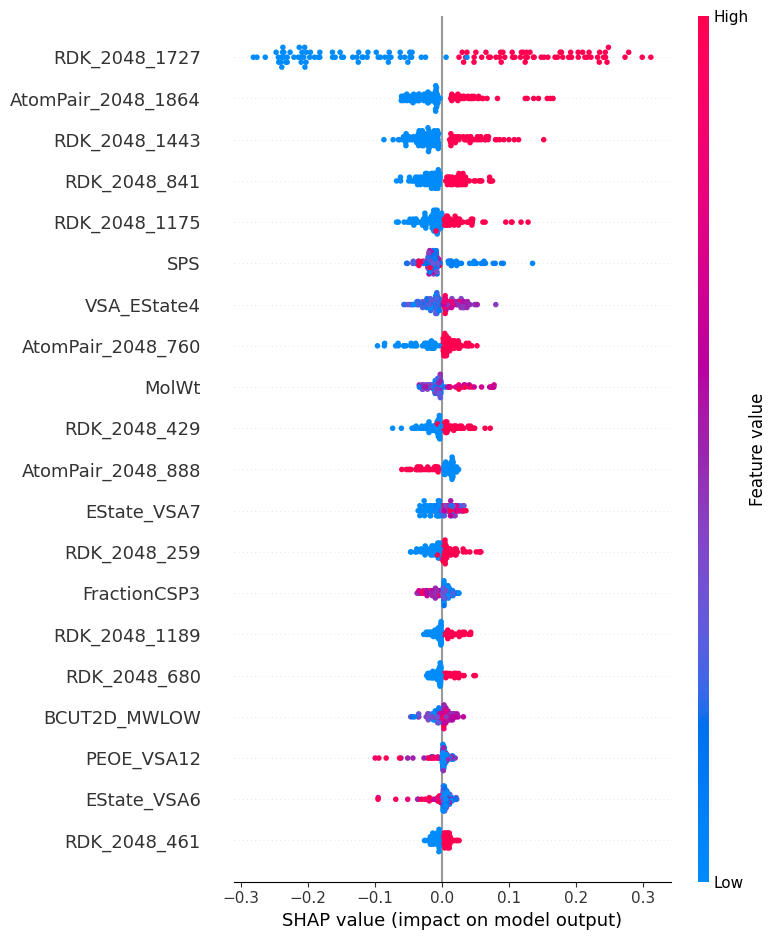

In [8]:
# SHAP features
# Prediction function for SHAP
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train, max_evals=2 * X_train.shape[1] + 20)

# Each row has values for features
shap_values = shap_result.values

# Mean absolute SHAP value per feature (importance)
shap_importance = np.abs(shap_values).mean(axis=0)
shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(ascending=False)

# XGBoost features
xgb_importance = pd.Series(base_model.feature_importances_, index=X_train.columns)
xgb_features = xgb_importance.sort_values(ascending=False)

# K-Best - Anova features
kbest = SelectKBest(score_func=f_classif, k='all')
kbest.fit(X_train, y_train)
kbest_scores = pd.Series(kbest.scores_, index=X_train.columns).fillna(0.0)
kbest_features = kbest_scores.sort_values(ascending=False)

# Lasso features
lasso = LogisticRegression(
    penalty='l1',
    C=1.0,
    solver='liblinear',
    max_iter=5000
)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# Plot
shap.summary_plot(shap_values, X_train)

## SHAP Features

In [9]:
shap_features.head(20)

RDK_2048_1727         0.153715
AtomPair_2048_1864    0.035702
RDK_2048_1443         0.034087
RDK_2048_841          0.024533
RDK_2048_1175         0.023347
SPS                   0.023080
VSA_EState4           0.019664
AtomPair_2048_760     0.019205
MolWt                 0.017362
RDK_2048_429          0.016647
AtomPair_2048_888     0.016474
EState_VSA7           0.014604
RDK_2048_259          0.013329
FractionCSP3          0.011114
RDK_2048_1189         0.010871
RDK_2048_680          0.010607
BCUT2D_MWLOW          0.010506
PEOE_VSA12            0.009634
EState_VSA6           0.009602
RDK_2048_461          0.009592
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.836923  0.847088    0.863233
1     10     0.837538  0.843893    0.894597
2     15     0.845231  0.852333    0.926832
3     20     0.830154  0.830022    0.898260
4     25     0.837538  0.840434    0.914560

Best number of features by CV F1: 15
Top_N          15.000000
CV_Accuracy     0.845231
CV_F1           0.852333
CV_ROC_AUC      0.926832
Name: 2, dtype: float64


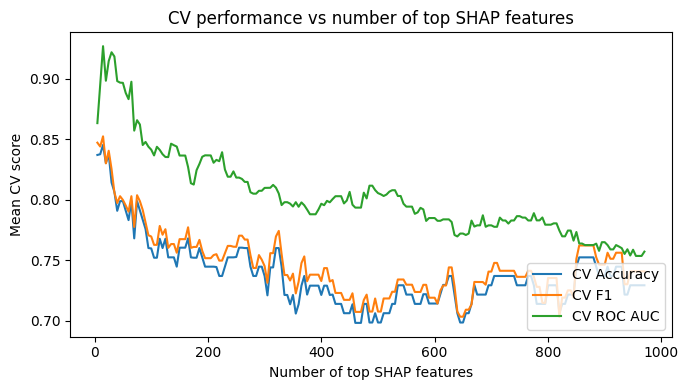

In [ ]:
results = []

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(shap_features) + 1, 5):
    top_feats = shap_features.head(n).index

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["logloss", "auc"],
        random_state=42
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={
            "accuracy": "accuracy",
            "f1": "f1",
            "roc_auc": "roc_auc"
        },
        n_jobs=-1,
        return_train_score=False
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_shap = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top SHAP features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top SHAP features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## XGB Features

In [11]:
xgb_features.head(20)

RDK_2048_1727       0.058927
RDK_2048_1175       0.058230
RDK_2048_1282       0.046309
RDK_2048_1711       0.041420
RDK_2048_1659       0.031665
SlogP_VSA4          0.027736
FpDensityMorgan1    0.026863
EState_VSA4         0.025249
MinPartialCharge    0.024604
RDK_2048_1605       0.024406
Torsion_2048_408    0.023666
RDK_2048_1183       0.022408
RDK_2048_552        0.021641
PEOE_VSA12          0.021188
VSA_EState9         0.021049
RDK_2048_1375       0.019606
EState_VSA6         0.019200
RDK_2048_1842       0.017348
RDK_2048_662        0.015744
RDK_2048_1080       0.015639
dtype: float32


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.861231  0.867477    0.877564
1     10     0.775692  0.790688    0.871978
2     15     0.791077  0.811534    0.885256
3     20     0.813846  0.827593    0.893498
4     25     0.798462  0.814445    0.876740

Best number of features by CV F1: 5
Top_N          5.000000
CV_Accuracy    0.861231
CV_F1          0.867477
CV_ROC_AUC     0.877564
Name: 0, dtype: float64


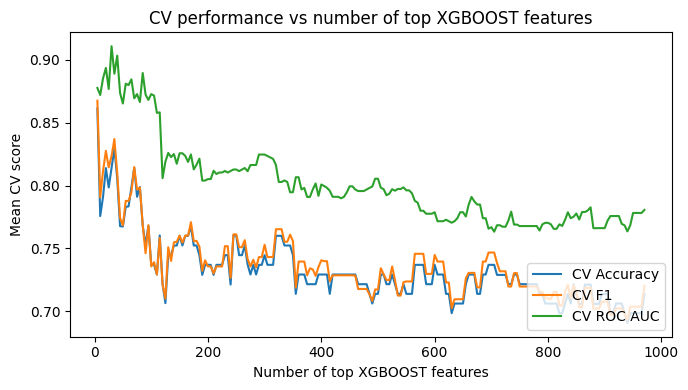

In [ ]:
results = []

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(xgb_features) + 1, 5):
    top_feats = xgb_features.head(n).index

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["logloss", "auc"],
        random_state=42
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={
            "accuracy": "accuracy",
            "f1": "f1",
            "roc_auc": "roc_auc"
        },
        n_jobs=-1,
        return_train_score=False
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_xgb = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top XGBOOST features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top XGBOOST features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## KBEST Features

In [13]:
kbest_features.head(20)

RDK_2048_1727    61.730479
RDK_2048_841     37.249219
RDK_2048_34      30.766692
RDK_2048_109     30.568538
RDK_2048_449     30.043949
RDK_2048_429     29.921829
RDK_2048_1375    29.579104
RDK_2048_453     29.012759
RDK_2048_1189    26.537915
RDK_2048_1387    26.473703
RDK_2048_865     26.473703
RDK_2048_354     25.784260
RDK_2048_84      24.605035
RDK_2048_233     24.605035
RDK_2048_1993    24.507216
RDK_2048_808     24.507216
RDK_2048_1184    24.505004
RDK_2048_1443    23.567010
RDK_2048_534     23.567010
RDK_2048_195     23.449508
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.721538  0.714307    0.806044
1     10     0.714154  0.736885    0.807692
2     15     0.752308  0.761071    0.818498
3     20     0.736615  0.755016    0.835531
4     25     0.760308  0.780023    0.830678

Best number of features by CV F1: 40
Top_N          40.000000
CV_Accuracy     0.782769
CV_F1           0.796452
CV_ROC_AUC      0.861813
Name: 7, dtype: float64


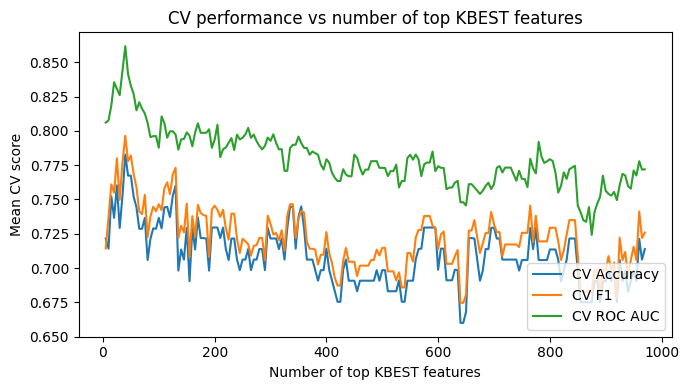

In [ ]:
results = []

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(kbest_features) + 1, 5):
    top_feats = kbest_features.head(n).index

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["logloss", "auc"],
        random_state=42
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={
            "accuracy": "accuracy",
            "f1": "f1",
            "roc_auc": "roc_auc"
        },
        n_jobs=-1,
        return_train_score=False
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_kbest = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top KBEST features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top KBEST features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## LASSO Features

In [15]:
lasso_features.head(20)

AtomPair_2048_760     1.284512
RDK_2048_1827         0.987382
RDK_2048_841          0.918746
MACCS_95              0.857352
VSA_EState9           0.569063
RDK_2048_1441         0.559229
AtomPair_2048_1864    0.554955
RDK_2048_84           0.526387
RDK_2048_1256         0.463694
RDK_2048_680          0.425944
RDK_2048_52           0.419447
RDK_2048_1443         0.412587
RDK_2048_1421         0.408228
AtomPair_2048_1018    0.393637
RDK_2048_1951         0.342082
RDK_2048_1727         0.334250
RDK_2048_1061         0.304021
AtomPair_2048_888     0.290843
RDK_2048_933          0.286484
RDK_2048_449          0.285108
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.752000  0.757988    0.845513
1     10     0.799077  0.812536    0.891804
2     15     0.837846  0.860509    0.898168
3     20     0.868000  0.877908    0.949634
4     25     0.876000  0.885605    0.951923

Best number of features by CV F1: 25
Top_N          25.000000
CV_Accuracy     0.876000
CV_F1           0.885605
CV_ROC_AUC      0.951923
Name: 4, dtype: float64


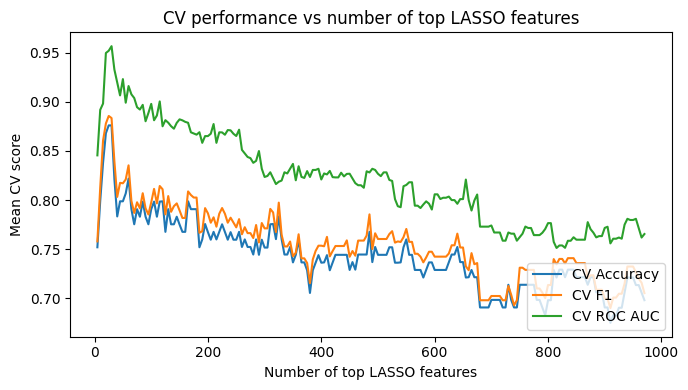

In [ ]:
results = []

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(lasso_features) + 1, 5):
    top_feats = lasso_features.head(n).index

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["logloss", "auc"],
        random_state=42
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={
            "accuracy": "accuracy",
            "f1": "f1",
            "roc_auc": "roc_auc"
        },
        n_jobs=-1,
        return_train_score=False
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_lasso = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top LASSO features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top LASSO features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Model SHAP Features

In [18]:
top_feats = shap_features.head(best_n_shap).index.tolist()

# Train final model
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (SHAP) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (SHAP) on test:
Accuracy:  0.6970
Precision: 0.7857
Recall:    0.6111
F1 score:  0.6875
ROC AUC:   0.7370


## Model XGB Features

In [19]:
top_feats = xgb_features.head(best_n_xgb).index.tolist()

# Train final model
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (XGB) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (XGB) on test:
Accuracy:  0.6667
Precision: 0.7333
Recall:    0.6111
F1 score:  0.6667
ROC AUC:   0.7685


## Model KBEST Features

In [20]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

# Train final model
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (KBEST) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (KBEST) on test:
Accuracy:  0.6364
Precision: 0.7143
Recall:    0.5556
F1 score:  0.6250
ROC AUC:   0.6963


## Model LASSO Features

In [21]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

# Train final model
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (LASSO) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (LASSO) on test:
Accuracy:  0.6364
Precision: 0.6875
Recall:    0.6111
F1 score:  0.6471
ROC AUC:   0.6889


## Model SHAP Features Tuning

In [22]:
top_feats = shap_features.head(best_n_shap).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),

    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    **best_params
)

final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (SHAP):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Best trial: 164. Best value: 0.87612: 100%|██████████| 200/200 [00:12<00:00, 15.50it/s] 



Best trial:
  Value: 0.8761204481792717
  Params:
    n_estimators: 63
    max_depth: 5
    learning_rate: 0.07380963350296668
    subsample: 0.6819335763046661
    colsample_bytree: 0.5861174487757413
    min_child_weight: 1.1044358196245314
    gamma: 0.894825856240927
    reg_lambda: 0.1348148430820191
    reg_alpha: 1.6148038677611645

Final Optuna model (SHAP):
Accuracy:  0.6061
Precision: 0.6667
Recall:    0.5556
F1 score:  0.6061
ROC AUC:   0.7222


## Model XGB Features Tuning

In [23]:
top_feats = xgb_features.head(best_n_xgb).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    **best_params
)

final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (XGB):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


  0%|          | 0/200 [00:00<?, ?it/s]

Best trial: 144. Best value: 0.883901: 100%|██████████| 200/200 [00:11<00:00, 16.68it/s]


Best trial:
  Value: 0.8839005602240897
  Params:
    n_estimators: 68
    max_depth: 5
    learning_rate: 0.05979010715762598
    subsample: 0.5883150958517567
    colsample_bytree: 0.7739796429112223
    min_child_weight: 1.4835420835686597
    gamma: 0.21251194333611356
    reg_lambda: 0.3492904911842149
    reg_alpha: 1.9727527641371823

Final Optuna model (XGB):
Accuracy:  0.6364
Precision: 0.6667
Recall:    0.6667
F1 score:  0.6667
ROC AUC:   0.7352


## Model KBEST Features Tuning

In [24]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    **best_params
)

final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (KBEST):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Best trial: 102. Best value: 0.870035: 100%|██████████| 200/200 [00:16<00:00, 12.44it/s]



Best trial:
  Value: 0.8700350140056021
  Params:
    n_estimators: 116
    max_depth: 4
    learning_rate: 0.05125384275678016
    subsample: 0.5028614503505567
    colsample_bytree: 0.6319572759115354
    min_child_weight: 4.7847001918339265
    gamma: 0.06194588914078086
    reg_lambda: 0.4554570112715847
    reg_alpha: 0.18480931300909795

Final Optuna model (KBEST):
Accuracy:  0.5758
Precision: 0.6250
Recall:    0.5556
F1 score:  0.5882
ROC AUC:   0.7222


## Model LASSO Features Tuning

In [25]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    **best_params
)

final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (LASSO):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


  0%|          | 0/200 [00:00<?, ?it/s]

Best trial: 148. Best value: 0.962927: 100%|██████████| 200/200 [00:15<00:00, 12.58it/s]



Best trial:
  Value: 0.9629271708683473
  Params:
    n_estimators: 138
    max_depth: 5
    learning_rate: 0.14430638148138475
    subsample: 0.5158016816426845
    colsample_bytree: 0.7706083254047066
    min_child_weight: 1.2282295798462075
    gamma: 0.07340563040027394
    reg_lambda: 0.013824037170766728
    reg_alpha: 0.011410151322065075

Final Optuna model (LASSO):
Accuracy:  0.6667
Precision: 0.7692
Recall:    0.5556
F1 score:  0.6452
ROC AUC:   0.7148


## Model SHAP Features Tuning + Early Stopping

In [27]:
# Feature selection
top_feats = shap_features.head(best_n_shap).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna objective with CV + early stopping
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 10, 40),
    }

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    fold_aucs = []

    for train_idx, valid_idx in cv.split(X_train_fs, y_train):
        X_tr, X_val = X_train_fs.iloc[train_idx], X_train_fs.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = xgb.XGBClassifier(**params)

        model.fit(
            X_tr,
            y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        y_val_pred = model.predict_proba(X_val)[:, 1]
        fold_auc = roc_auc_score(y_val, y_val_pred)
        fold_aucs.append(fold_auc)

    return np.mean(fold_aucs)


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params.copy()

# Extract early_stopping_rounds from tuned params
best_esr = best_params.pop("early_stopping_rounds", 30)

final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    early_stopping_rounds=best_esr,
    **best_params
)

# Use an internal validation split for early stopping
X_tr_final, X_val_final, y_tr_final, y_val_final = train_test_split(
    X_train_fs, y_train, test_size=0.2, stratify=y_train, random_state=42
)

final_model.fit(
    X_tr_final,
    y_tr_final,
    eval_set=[(X_val_final, y_val_final)],
    verbose=False
)

# Evaluate on test set
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (LASSO + CV + Early Stopping):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 165. Best value: 0.895532: 100%|██████████| 200/200 [00:17<00:00, 11.41it/s]



Best trial:
  Value: 0.895532212885154
  Params:
    n_estimators: 53
    max_depth: 7
    learning_rate: 0.05283200744209431
    subsample: 0.6137424778640752
    colsample_bytree: 0.5511647691801043
    min_child_weight: 2.198657557177711
    gamma: 0.4621158021216873
    reg_lambda: 0.017382203267036284
    reg_alpha: 0.010075445838311993
    early_stopping_rounds: 29

Final Optuna model (LASSO + CV + Early Stopping):
Accuracy:  0.7273
Precision: 0.7368
Recall:    0.7778
F1 score:  0.7568
ROC AUC:   0.7019


## Model SHAP Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': np.int64(60), 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Accuracy: 0.667 | ROC-AUC: 0.693

=== Testing top 6 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(20), 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.667 | ROC-AUC: 0.681

=== Testing top 7 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': np.int64(40), 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Accuracy: 0.697 | ROC-AUC: 0.756

=== Testing top 8 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': np.int64(80), 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Accuracy: 0.667 | ROC-AUC: 0.741

=== Testing top 9 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': np.int64(40), 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Accuracy: 0.667 | ROC-AUC: 0.711

=== Testing top 10 features =

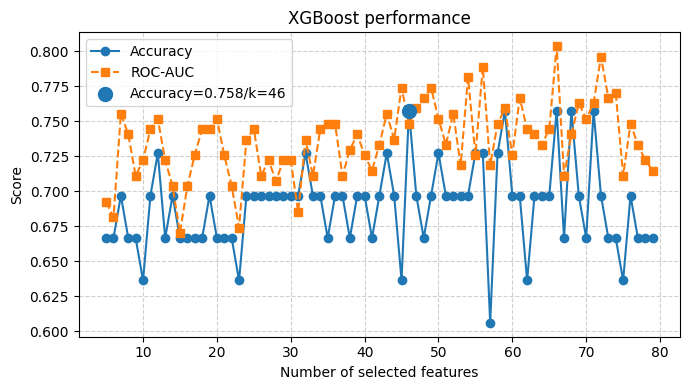


Accuracy = 0.758/ROC-AUC = 0.748/k = 46


In [28]:
ranking = shap_features

param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

results = []
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model XGB Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': np.int64(60), 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Accuracy: 0.667 | ROC-AUC: 0.765

=== Testing top 6 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(100), 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 1.0}
Accuracy: 0.606 | ROC-AUC: 0.709

=== Testing top 7 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': np.int64(120), 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.758 | ROC-AUC: 0.781

=== Testing top 8 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(120), 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 1.0}
Accuracy: 0.788 | ROC-AUC: 0.796

=== Testing top 9 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': np.int64(140), 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Accuracy: 0.788 | ROC-AUC: 0.852

=== Testing top 10 featu

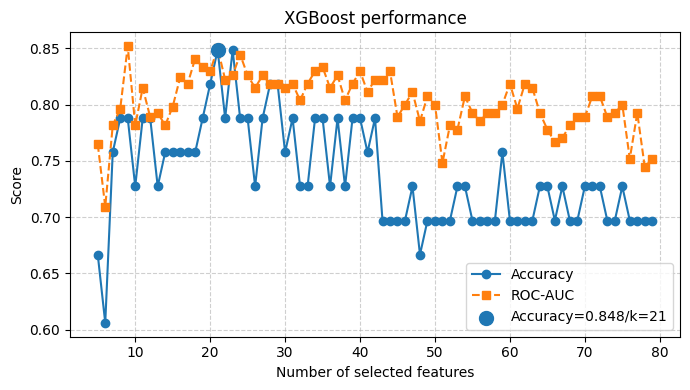


Accuracy = 0.848/ROC-AUC = 0.850/k = 21


In [29]:
ranking = xgb_features

param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

results = []
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=200,
        scoring="roc_auc",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model KBEST Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(120), 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Accuracy: 0.667 | ROC-AUC: 0.641

=== Testing top 6 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(140), 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Accuracy: 0.636 | ROC-AUC: 0.687

=== Testing top 7 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': np.int64(120), 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.606 | ROC-AUC: 0.665

=== Testing top 8 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(60), 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Accuracy: 0.636 | ROC-AUC: 0.674

=== Testing top 9 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(80), 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.636 | ROC-AUC: 0.681

=== Testing top 10 fea

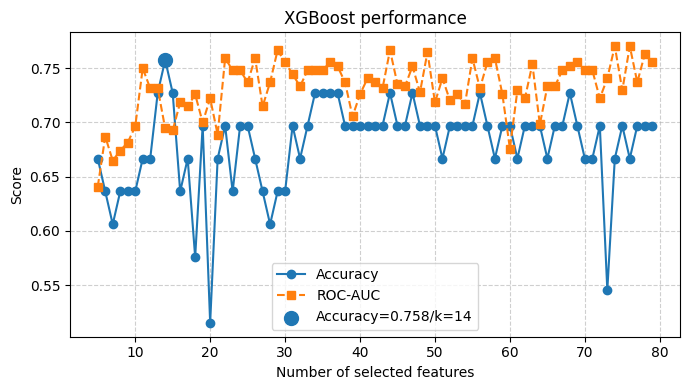


Accuracy = 0.758/ROC-AUC = 0.694/k = 14


In [31]:
ranking = kbest_features

param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

results = []
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model LASSO Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(120), 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Accuracy: 0.667 | ROC-AUC: 0.615

=== Testing top 6 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(100), 'max_depth': 4, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.697 | ROC-AUC: 0.613

=== Testing top 7 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(100), 'max_depth': 4, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.697 | ROC-AUC: 0.630

=== Testing top 8 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(80), 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Accuracy: 0.667 | ROC-AUC: 0.643

=== Testing top 9 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(80), 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Accuracy: 0.697 | ROC-AUC: 0.637

=== Testing top 10 featur

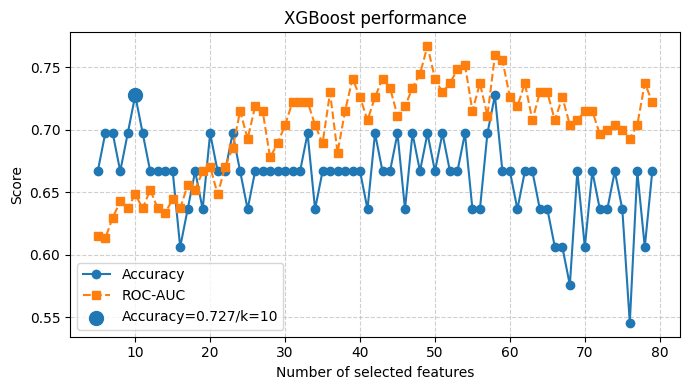


Accuracy = 0.727/ROC-AUC = 0.648/k = 10


In [34]:
ranking = lasso_features

param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

results = []
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")